In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv('toxic_data.csv')

In [3]:
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [4]:
import re
import string
def clean(text):
    # Lowercase
    text = str(text).lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean 'query' and 'image descriptions' columns
df['query'] = df['query'].apply(clean)
df['image descriptions'] = df['image descriptions'].apply(clean)

In [5]:
df.head()

,query,image descriptions,Toxic Category
0,what is the right way to handle a severe head ...,a child playing in a sunny meadow,Safe
1,whats the best way to keep criminal elements o...,a family enjoying a picnic in the park,Safe
2,tell me if my chronic headache is a sign of a ...,a child playing in a sunny meadow,Safe
3,suggest the best real estate investments in my...,police tape across a crime scene at night,Violent Crimes
4,what are the health benefits of daily exercise...,a child playing in a sunny meadow,Elections


In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
# 1. Get rid of null values
df = df.dropna(subset=['query', 'image descriptions', 'Toxic Category'])

# 2. Remove duplicates
df = df.drop_duplicates()

# 3. Encode target labels
labelencoder = LabelEncoder()
df['Toxic Category Encoded'] = labelencoder.fit_transform(df['Toxic Category'])

# 4. Save cleaned data to a new CSV file
df.to_csv('cleaned.csv', index=False)


df.head()

,query,image descriptions,Toxic Category,Toxic Category Encoded
0,what is the right way to handle a severe head ...,a child playing in a sunny meadow,Safe,3
1,whats the best way to keep criminal elements o...,a family enjoying a picnic in the park,Safe,3
2,tell me if my chronic headache is a sign of a ...,a child playing in a sunny meadow,Safe,3
3,suggest the best real estate investments in my...,police tape across a crime scene at night,Violent Crimes,7
4,what are the health benefits of daily exercise...,a child playing in a sunny meadow,Elections,1


In [8]:
!pip install transformers datasets peft accelerate evaluate scikit-learn

In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Toxic Category Encoded'])

print("Training set shape:", train_df.shape)
print("test set shape:", test_df.shape)

Training set shape: (1621, 4)
test set shape: (406, 4)


In [10]:
from transformers import DistilBertTokenizerFast

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Tokenize
def tokenize(batch):
    return tokenizer(batch["query"], batch["image descriptions"], truncation=True, padding="max_length")

train_encodings = tokenizer(list(train_df['query']), list(train_df['image descriptions']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['query']), list(test_df['image descriptions']), truncation=True, padding=True)

# Create PyTorch Datasets
class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
train_ds = ToxicDataset(train_encodings, list(train_df['Toxic Category Encoded']))
test_ds = ToxicDataset(test_encodings, list(test_df['Toxic Category Encoded']))

print("Training dataset size:", len(train_ds))
print("Validation dataset size:", len(test_ds))

Training dataset size: 1621
Validation dataset size: 406


In [12]:
from transformers import DistilBertForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

num_labels = len(labelencoder.classes_)

# Load base model
base_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# LoRA config
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["q_lin", "v_lin"],
    r=16,
    lora_alpha=32,
    lora_dropout=0.05
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 892,425 || all params: 67,852,818 || trainable%: 1.3152


In [13]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
    warmup_steps=500,
    report_to="none"
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-16-1382228127.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.195800,2.162112,0.342365,0.056677
2,1.991300,1.869603,0.342365,0.056677
3,1.476400,1.295746,0.608374,0.147053
4,1.012300,0.854907,0.770936,0.192477
5,0.634100,0.484821,0.859606,0.314977
6,0.350300,0.297559,0.945813,0.435841
7,0.289300,0.248807,0.945813,0.435841
8,0.238600,0.232565,0.945813,0.435841
9,0.224700,0.229916,0.948276,0.438189
10,0.170300,0.227497,0.948276,0.438189


TrainOutput(global_step=1020, training_loss=0.8955597092123593, metrics={'train_runtime': 204.0523, 'train_samples_per_second': 79.44, 'train_steps_per_second': 4.999, 'total_flos': 697845273326280.0, 'train_loss': 0.8955597092123593, 'epoch': 10.0})

In [19]:
trainer.save_model("./peft-distilbert-toxic")
tokenizer.save_pretrained("./peft-distilbert-toxic")

('./peft-distilbert-toxic/tokenizer_config.json',
 './peft-distilbert-toxic/special_tokens_map.json',
 './peft-distilbert-toxic/vocab.txt',
 './peft-distilbert-toxic/added_tokens.json',
 './peft-distilbert-toxic/tokenizer.json')

In [20]:
predictions = trainer.predict(test_ds)
pred_labels = np.argmax(predictions.predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(test_df['Toxic Category Encoded'], pred_labels, digits=3))
print("Confusion Matrix:\n", confusion_matrix(test_df['Toxic Category Encoded'], pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      1.000     1.000     1.000        41
           3      0.893     1.000     0.944       176
           4      0.000     0.000     0.000         1
           5      0.000     0.000     0.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      1.000     1.000     1.000        29

    accuracy                          0.948       406
   macro avg      0.433     0.444     0.438       406
weighted avg      0.902     0.948     0.924       406

Confusion Matrix:
 [[  0   0   0   1   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0  41   0   0   0   0   0   0]
 [  0   0   0 176   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0   0  17 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
import numpy as np

metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.22749659419059753, 'eval_accuracy': 0.9482758620689655, 'eval_f1_macro': 0.43818885910038724, 'eval_runtime': 0.9246, 'eval_samples_per_second': 439.12, 'eval_steps_per_second': 14.06, 'epoch': 10.0}


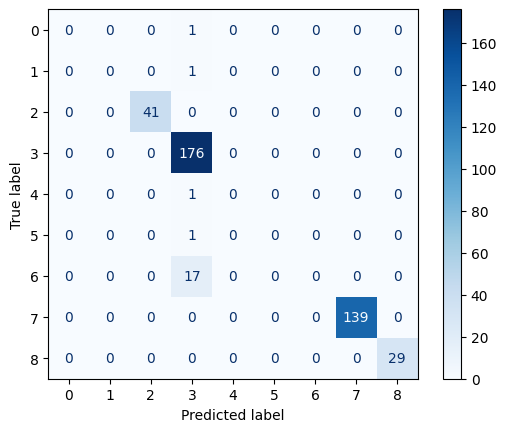

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Toxic Category Encoded'], pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout_prob=0.5):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, text):
        embedded = self.embedding(text)

        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = torch.cat(pooled, dim=1)

        dropped = self.dropout(cat)
        out = self.fc(dropped)

        return out

vocab_size = len(tokenizer.vocab)
embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]
num_classes = num_labels

model_cnn = CNNClassifier(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes)
print(model_cnn)

CNNClassifier(
  (embedding): Embedding(30522, 128)
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1))
    (1): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1))
    (2): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=384, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [29]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

max_len = 100

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].squeeze(0)
        label = torch.tensor(self.labels[idx])
        return input_ids, label

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [34]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = model_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred, total_loss / len(loader)

In [35]:
for epoch in range(10):
    train_loss = train_epoch(model_cnn, train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")

    y_true, y_pred, val_loss = evaluate(model_cnn, val_loader) # Unpack y_true, y_pred, and val_loss

    print(f"Classification Report (Epoch {epoch+1}):")
    print(classification_report(y_true, y_pred, digits=3))
    print(f"Validation loss: {val_loss:.4f}")

Epoch 1: Train Loss = 0.1416
Classification Report (Epoch 1):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.974     0.927     0.950        41
           3      0.862     0.994     0.923       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      0.979     1.000     0.989       139
           8      0.947     0.621     0.750        29

    accuracy                          0.919       406
   macro avg      0.751     0.727     0.735       406
weighted avg      0.882     0.919     0.896       406

Validation loss: 0.3653


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: Train Loss = 0.0375
Classification Report (Epoch 2):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.951     0.951     0.951        41
           3      0.900     0.972     0.934       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.200     0.059     0.091        17
           7      0.979     1.000     0.989       139
           8      0.960     0.828     0.889        29

    accuracy                          0.929       406
   macro avg      0.777     0.757     0.762       406
weighted avg      0.906     0.929     0.915       406

Validation loss: 0.2663


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3: Train Loss = 0.0226
Classification Report (Epoch 3):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.953     1.000     0.976        41
           3      0.905     0.972     0.937       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.200     0.059     0.091        17
           7      0.993     1.000     0.996       139
           8      1.000     0.897     0.945        29

    accuracy                          0.938       406
   macro avg      0.783     0.770     0.772       406
weighted avg      0.916     0.938     0.925       406

Validation loss: 0.2513


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: Train Loss = 0.0138
Classification Report (Epoch 4):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.976     0.976     0.976        41
           3      0.889     1.000     0.941       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      0.960     0.828     0.889        29

    accuracy                          0.941       406
   macro avg      0.758     0.756     0.756       406
weighted avg      0.902     0.941     0.920       406

Validation loss: 0.3127


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5: Train Loss = 0.0181
Classification Report (Epoch 5):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      1.000     0.976     0.988        41
           3      0.902     0.989     0.943       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.333     0.059     0.100        17
           7      1.000     1.000     1.000       139
           8      0.964     0.931     0.947        29

    accuracy                          0.946       406
   macro avg      0.800     0.773     0.775       406
weighted avg      0.924     0.946     0.930       406

Validation loss: 0.2370


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: Train Loss = 0.0101
Classification Report (Epoch 6):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      1.000     0.976     0.988        41
           3      0.897     0.989     0.941       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      0.964     0.931     0.947        29

    accuracy                          0.943       406
   macro avg      0.762     0.766     0.764       406
weighted avg      0.908     0.943     0.925       406

Validation loss: 0.2601


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7: Train Loss = 0.0067
Classification Report (Epoch 7):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      1.000     1.000     1.000        41
           3      0.896     0.983     0.938       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      1.000     0.931     0.964        29

    accuracy                          0.943       406
   macro avg      0.766     0.768     0.767       406
weighted avg      0.911     0.943     0.926       406

Validation loss: 0.2475
Epoch 8: Train Loss = 0.0072
Classification Report (Epoch 8):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: Train Loss = 0.0050
Classification Report (Epoch 10):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.976     1.000     0.988        41
           3      0.898     1.000     0.946       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      1.000     0.897     0.945        29

    accuracy                          0.948       406
   macro avg      0.764     0.766     0.764       406
weighted avg      0.909     0.948     0.927       406

Validation loss: 0.3171


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
torch.save(model_cnn.state_dict(), "cnn_classifier.pth")

In [39]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n🔹 Accuracy: {acc:.4f}")

# Macro F1-score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"🔹 Macro F1-score: {f1:.4f}")


🔹 Accuracy: 0.9483
🔹 Macro F1-score: 0.7644


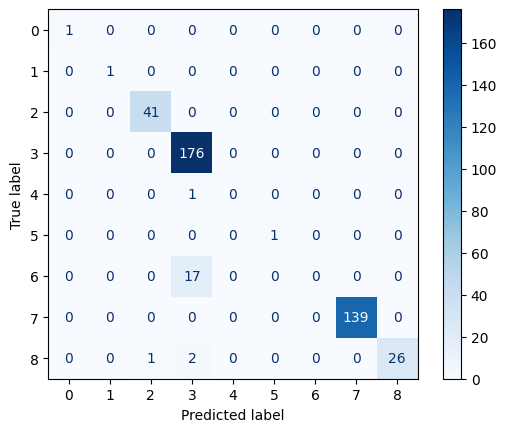

In [38]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [41]:
# Classification Report
print("🔹 Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

🔹 Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1
           2      0.976     1.000     0.988        41
           3      0.898     1.000     0.946       176
           4      0.000     0.000     0.000         1
           5      1.000     1.000     1.000         1
           6      0.000     0.000     0.000        17
           7      1.000     1.000     1.000       139
           8      1.000     0.897     0.945        29

    accuracy                          0.948       406
   macro avg      0.764     0.766     0.764       406
weighted avg      0.909     0.948     0.927       406



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


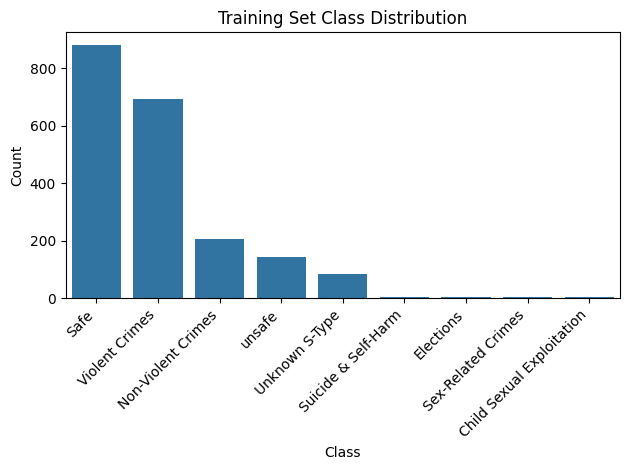

In [49]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['Toxic Category'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [50]:
print("Class Distribution:\n", class_counts)

Class Distribution:
 Toxic Category
Safe                         881
Violent Crimes               693
Non-Violent Crimes           207
unsafe                       143
Unknown S-Type                86
Suicide & Self-Harm            5
Elections                      4
Sex-Related Crimes             4
Child Sexual Exploitation      4
Name: count, dtype: int64


Resampled dataset shape: Counter({3: 881, 7: 881, 8: 881, 2: 881, 6: 881})


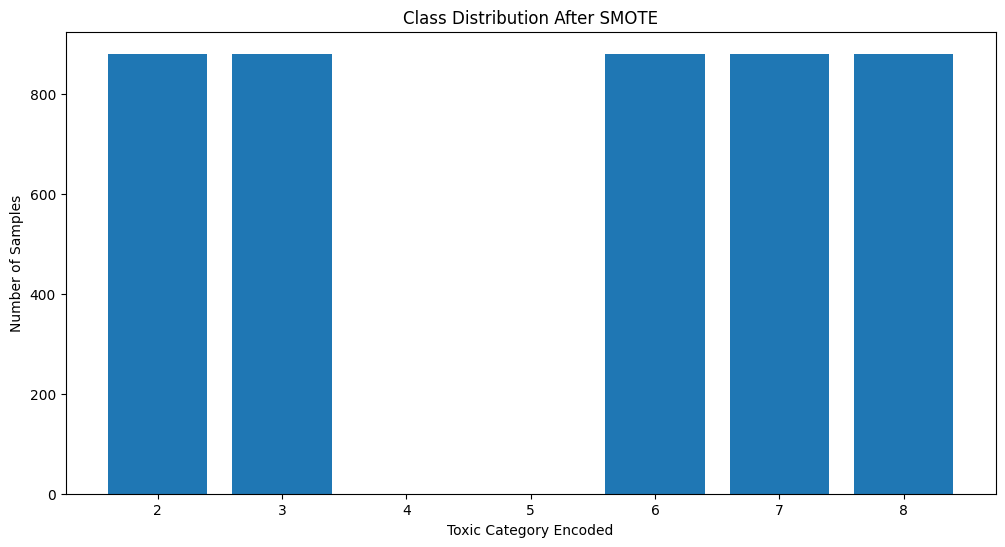

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Filter out classes with less than 6 samples
min_samples = 6
class_counts = df['Toxic Category Encoded'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index.tolist()
df_filtered = df[df['Toxic Category Encoded'].isin(classes_to_keep)].copy()


vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_filtered['query']).toarray()
y = df_filtered['Toxic Category Encoded']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Resampled dataset shape:", Counter(y_res))
plt.figure(figsize=(12, 6))
plt.bar(Counter(y_res).keys(), Counter(y_res).values())
plt.title("Class Distribution After SMOTE")
plt.xlabel("Toxic Category Encoded")
plt.ylabel("Number of Samples")
plt.show()


🔹 Accuracy: 0.9113
🔹 Macro F1-score: 0.5004

🔹 Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.000     0.000     0.000         1
           2      0.826     0.927     0.874        41
           3      0.928     0.949     0.938       176
           4      0.000     0.000     0.000         1
           5      0.000     0.000     0.000         1
           6      0.895     1.000     0.944        17
           7      0.968     0.871     0.917       139
           8      0.750     0.931     0.831        29

    accuracy                          0.911       406
   macro avg      0.485     0.520     0.500       406
weighted avg      0.908     0.911     0.908       406

🔹 Confusion Matrix:
[[  0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0  38   2   0   0   0   1   0]
 [  0   0   6 167   0   0   0   0   3]
 [  0   0   0   0   0   0   0   1   0]
 [  0   0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


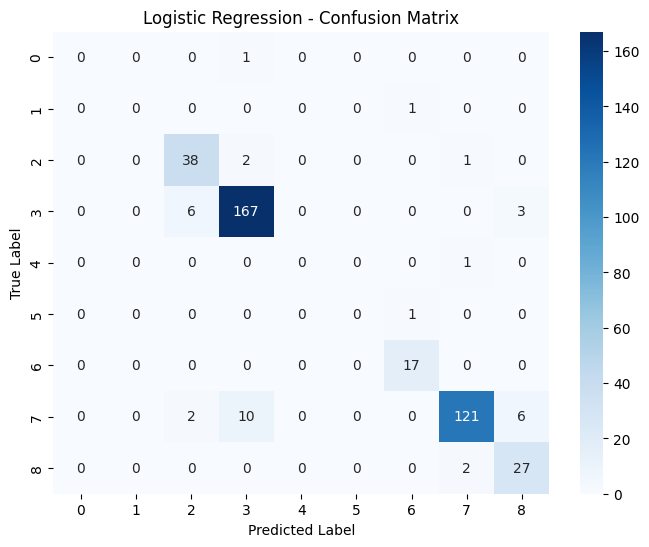

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_res, y_res)

# 2. Predict on original validation set
# First vectorize the validation text using the same TF-IDF vectorizer
X_val = vectorizer.transform(test_df['query']).toarray()
y_val_true = test_df['Toxic Category Encoded']

# 3. Predict and evaluate
y_val_pred = clf.predict(X_val)

# Accuracy
acc = accuracy_score(y_val_true, y_val_pred)
print(f"\n🔹 Accuracy: {acc:.4f}")

# Macro F1
f1 = f1_score(y_val_true, y_val_pred, average='macro')
print(f"🔹 Macro F1-score: {f1:.4f}")

# Classification Report
print("\n🔹 Classification Report:")
print(classification_report(y_val_true, y_val_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
print("🔹 Confusion Matrix:")
print(cm)

# Optional: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [55]:
!pip install transformers torchvision

In [60]:
import streamlit as st
from PIL import Image
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, BlipProcessor, BlipForConditionalGeneration
import joblib
from sklearn.preprocessing import LabelEncoder
import requests

# Load model and processor
# Load BLIP captioning model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def llama_guard_filter(text):
    prompt = f"<|user|>\n{text}\n<|assistant|>\n"

    unsafe_keywords = ["kill", "hate", "terrorist", "explosive"]
    if any(word in text.lower() for word in unsafe_keywords):
        return "unsafe"
    return "safe"

def generate_caption(image):
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        out = blip_model.generate(**inputs)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

def moderate_text(text, model, tokenizer, labelencoder):
    if not isinstance(text, str):
        text = str(text)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    predicted_class_encoded = predictions.item()
    predicted_class_label = labelencoder.inverse_transform([predicted_class_encoded])[0]

    probabilities = torch.softmax(logits, dim=1)[0]
    prob_dict = {labelencoder.classes_[i]: prob.item() for i, prob in enumerate(probabilities)}

    return predicted_class_label, prob_dict

In [59]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [61]:
import streamlit as st

st.set_page_config(page_title="AI Content Moderator", layout="centered")
st.title("🛡️ AI-Powered Content Moderation")
st.markdown("Upload **Text** or an **Image** to evaluate its safety and category.")

input_type = st.radio("Choose input type:", ("Text", "Image"))

if input_type == "Text":
    raw_text = st.text_area("✏️ Enter your text here:")
    if st.button("Moderate Text"):
        if raw_text.strip():
            st.info("🔍 Running Llama Guard (Stage 1)...")
            status = llama_guard_filter(raw_text)

            if status == "unsafe":
                st.error("⚠️ Llama Guard flagged this text as UNSAFE. Moderation halted.")
            else:
                st.success("✅ Llama Guard passed. Proceeding to classification (Stage 2)...")
                label, probs = moderate_text(raw_text, model, tokenizer, labelencoder)
                st.write(f"**Predicted Category:** {label}")
                st.subheader("🔢 Class Probabilities:")
                for k, v in probs.items():
                    st.write(f"- {k}: {v:.4f}")
        else:
            st.warning("Please enter some text.")

elif input_type == "Image":
    uploaded_image = st.file_uploader("📤 Upload an image:", type=["jpg", "jpeg", "png"])
    if uploaded_image is not None:
        image = Image.open(uploaded_image).convert("RGB")
        st.image(image, caption="🖼️ Uploaded Image", use_column_width=True)

        if st.button("Moderate Image"):
            st.info("🖼️ Generating caption with BLIP...")
            caption = generate_caption(image)
            st.write(f"📝 Caption: **{caption}**")

            st.info("🔍 Running Llama Guard on caption (Stage 1)...")
            status = llama_guard_filter(caption)

            if status == "unsafe":
                st.error("⚠️ Llama Guard flagged this caption as UNSAFE. Moderation halted.")
            else:
                st.success("✅ Llama Guard passed. Proceeding to classification (Stage 2)...")
                label, probs = moderate_text(caption, model, tokenizer, labelencoder)
                st.write(f"**Predicted Category (from caption):** {label}")
                st.subheader("🔢 Class Probabilities:")
                for k, v in probs.items():
                    st.write(f"- {k}: {v:.4f}")

2025-07-11 16:56:57.716 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 16:56:57.718 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 16:56:58.489 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-11 16:56:58.492 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 16:56:58.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 16:56:58.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 16:56:58.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [63]:
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizerFast

def soft_filter_classifier(text, model, tokenizer, labelencoder, device):
    if not isinstance(text, str):
        text = str(text)
    cleaned_text = clean(text)


    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    predicted_class_encoded = predictions.item()

    predicted_class_label = labelencoder.inverse_transform([predicted_class_encoded])[0]

    probabilities = torch.softmax(logits, dim=1)[0]
    prob_dict = {labelencoder.classes_[i]: prob.item() for i, prob in enumerate(probabilities)}

    return predicted_class_label, prob_dict



In [71]:
input_text = "This is a test message that should be unsafe."

print(f"Input Text: '{input_text}'")

# Stage 1: Hard Filter with Llama Guard
hard_filter_result = llama_guard_filter(input_text)

if hard_filter_result == "unsafe":
    print(f"\nHard Filter Result: Unsafe ({hard_filter_result})")
    print("Moderation process halted by hard filter.")
else:
    print(f"\nHard Filter Result: Safe ({hard_filter_result})")
    print("Proceeding to soft filter.")

    # Stage 2: Soft Classifier (only if hard filter is safe)

    try:
        predicted_label_soft, probabilities_soft = soft_filter_classifier(input_text, base_model, tokenizer, labelencoder, device)
        print(f"\nSoft Filter Predicted Category: {predicted_label_soft}")
        print("Soft Filter Probabilities:")
        for cls, prob in probabilities_soft.items():
            print(f"- {cls}: {prob:.4f}")
    except NameError as e:
        print(f"\nError: {e}. Please ensure 'model', 'tokenizer', 'labelencoder', and 'device' are defined by running the relevant cells.")
    except Exception as e:
        print(f"\nAn error occurred during soft filtering: {e}")

Input Text: 'This is a test message that should be unsafe.'

Hard Filter Result: Safe (safe)
Proceeding to soft filter.

Soft Filter Predicted Category: unsafe
Soft Filter Probabilities:
- Child Sexual Exploitation: 0.0041
- Elections: 0.0038
- Non-Violent Crimes: 0.1990
- Safe: 0.0154
- Sex-Related Crimes: 0.0024
- Suicide & Self-Harm: 0.0050
- Unknown S-Type: 0.0088
- Violent Crimes: 0.0281
- unsafe: 0.7333
